In [1]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train['emission']

0         3.750994
1         4.025176
2         4.231381
3         4.305286
4         4.347317
           ...    
79018    29.404171
79019    29.186497
79020    29.131205
79021    28.125792
79022    27.239302
Name: emission, Length: 79023, dtype: float64

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79023 entries, 0 to 79022
Data columns (total 76 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   ID_LAT_LON_YEAR_WEEK                                      79023 non-null  object 
 1   latitude                                                  79023 non-null  float64
 2   longitude                                                 79023 non-null  float64
 3   year                                                      79023 non-null  int64  
 4   week_no                                                   79023 non-null  int64  
 5   SulphurDioxide_SO2_column_number_density                  64414 non-null  float64
 6   SulphurDioxide_SO2_column_number_density_amf              64414 non-null  float64
 7   SulphurDioxide_SO2_slant_column_number_density            64414 non-null  float64
 8   SulphurDioxide_c

In [5]:
train_df = train.copy()
test_df = test.copy()
train_df = train_df.select_dtypes(include = ['float64', 'int64'])
test_df = test_df.select_dtypes(include = ['float64', 'int64'])
train_df.shape

(79023, 75)

In [6]:
# Preprocess the data 

# Remove NULL values
# Find cols with NULL
def find_null_cols(df):
    is_null = df.isna().any()
    return [col for col in is_null.index]

# Flag columns that are at least 50% NULL
def flag_null_cols(df, null_cutoff):
    null_cols = find_null_cols(df)
    return [col for col in null_cols if df[col].isna().sum() / df[col].shape >= null_cutoff]

null_train_cols = flag_null_cols(train_df, 0.75)

In [7]:
# Remove flagged columns 
train_df.drop(columns=null_train_cols, inplace=True)
train_df.shape

(79023, 68)

In [8]:
# Do something about remaining NULL values--imputation?
train_df.fillna(train_df.mean(), inplace=True)

In [9]:
# Average emission by year
avg_em_year = train_df.groupby(['year']).agg('mean').reset_index()[['year', 'emission']]
avg_em_year

,year,emission
0,2019,87.255317
1,2020,75.992122
2,2021,82.574217


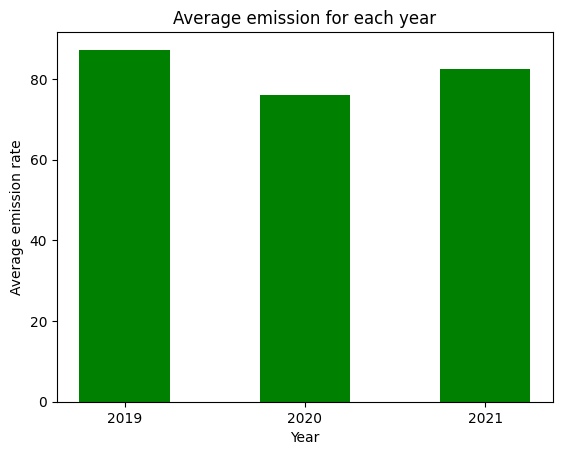

In [10]:
# Plot avg emission by year
plt.bar(avg_em_year['year'].astype(str), avg_em_year['emission'],color = 'green', width =0.5)
plt.xlabel("Year")
plt.ylabel("Average emission rate")
plt.title("Average emission for each year")
plt.show()

In [11]:
from sklearn.feature_selection import VarianceThreshold
var_thres = VarianceThreshold(threshold = 0.001)
var_thres.fit(train_df)
var_thres.get_support()

array([ True,  True,  True,  True, False,  True, False,  True,  True,
        True,  True,  True, False, False,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [12]:
const_cols = [col for col in train_df.columns if col not in train_df.columns[var_thres.get_support()]]
const_cols

['SulphurDioxide_SO2_column_number_density',
 'SulphurDioxide_SO2_slant_column_number_density',
 'SulphurDioxide_SO2_column_number_density_15km',
 'CarbonMonoxide_CO_column_number_density',
 'NitrogenDioxide_NO2_column_number_density',
 'NitrogenDioxide_tropospheric_NO2_column_number_density',
 'NitrogenDioxide_stratospheric_NO2_column_number_density',
 'NitrogenDioxide_NO2_slant_column_number_density',
 'Formaldehyde_tropospheric_HCHO_column_number_density',
 'Formaldehyde_HCHO_slant_column_number_density',
 'Ozone_O3_column_number_density',
 'Ozone_O3_slant_column_number_density']

In [13]:
train_df.drop(columns=const_cols, inplace=True)

In [14]:
def correlation(ds, threshold):
    col_corr = set()
    corr_matrix = ds.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                col_name = corr_matrix.columns[i]
                col_corr.add(col_name)
    return col_corr

In [15]:
corr_features = correlation(train_df, 0.8)
corr_features

{'CarbonMonoxide_solar_azimuth_angle',
 'Cloud_cloud_base_height',
 'Cloud_cloud_base_pressure',
 'Cloud_cloud_fraction',
 'Cloud_cloud_top_height',
 'Cloud_solar_azimuth_angle',
 'Cloud_solar_zenith_angle',
 'Formaldehyde_solar_azimuth_angle',
 'NitrogenDioxide_solar_azimuth_angle',
 'Ozone_O3_column_number_density_amf',
 'Ozone_sensor_azimuth_angle',
 'Ozone_sensor_zenith_angle',
 'Ozone_solar_azimuth_angle',
 'Ozone_solar_zenith_angle',
 'UvAerosolIndex_solar_azimuth_angle',
 'UvAerosolIndex_solar_zenith_angle'}

In [16]:
train_df.drop(corr_features, axis = 1)

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,...,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle,emission
0,-0.510,29.290,2019,0,0.603019,0.255668,-98.593887,50.843559,-130.050797,35.874496,...,-12.628979,35.632416,225.731144,0.595473,53534.732422,15.568533,0.272292,-12.628986,35.632416,3.750994
1,-0.510,29.290,2019,1,0.728214,0.130988,16.592861,39.137194,-140.874435,28.965133,...,16.152492,43.485327,226.172170,0.175166,63790.296241,8.690601,0.256830,30.359375,39.557633,4.025176
2,-0.510,29.290,2019,2,0.748199,0.110018,72.795837,52.868816,-150.191757,23.206415,...,-41.557633,41.269033,227.469292,0.606091,55923.790554,21.103410,0.251101,15.377883,30.401823,4.231381
3,-0.510,29.290,2019,3,0.834848,0.158418,-7.925870,37.436189,-83.833174,27.722311,...,-0.001270,34.458740,225.589440,0.787398,44569.130636,15.386899,0.262043,-11.293399,24.380357,4.305286
4,-0.510,29.290,2019,4,0.676296,0.121164,4.121269,35.515587,-137.409159,24.331972,...,-0.604325,41.794705,228.955840,0.215739,59904.314844,8.114694,0.235847,38.532263,37.392979,4.347317
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79018,-3.299,30.301,2021,48,1.195643,0.191313,72.820518,55.988022,-140.821274,25.148563,...,-35.142825,40.093391,230.769565,0.770152,54703.511452,20.245954,0.304797,-35.140368,40.113533,29.404171
79019,-3.299,30.301,2021,49,1.130868,0.177222,-12.856753,19.435339,-131.114411,31.197638,...,-13.034698,42.519018,230.288069,0.451318,53983.493958,6.104610,0.314015,4.667058,47.528435,29.186497
79020,-3.299,30.301,2021,50,0.834848,0.158418,-7.925870,37.436189,-83.833174,27.722311,...,-0.346926,35.359190,229.407711,0.846234,49904.738442,14.817885,0.288058,-0.340922,35.328098,29.131205
79021,-3.299,30.301,2021,51,0.879397,0.184209,-100.344827,32.599393,-129.573396,33.906037,...,8.424284,48.277884,229.638952,0.792553,41395.313100,32.594768,0.274047,8.427699,48.295652,28.125792


In [17]:
x = train_df.drop(columns = 'emission')
y = train['emission']

In [18]:
null_test_cols = flag_null_cols(test_df, 0.75)
test_df.drop(columns=null_test_cols, inplace=True)
test_df.fillna(test_df.mean(), inplace=True)
test_df.drop(const_cols, axis=1, inplace=True)
test_df.drop(corr_features, axis=1)

,latitude,longitude,year,week_no,SulphurDioxide_SO2_column_number_density_amf,SulphurDioxide_cloud_fraction,SulphurDioxide_sensor_azimuth_angle,SulphurDioxide_sensor_zenith_angle,SulphurDioxide_solar_azimuth_angle,SulphurDioxide_solar_zenith_angle,...,UvAerosolIndex_sensor_altitude,UvAerosolIndex_sensor_azimuth_angle,UvAerosolIndex_sensor_zenith_angle,Ozone_O3_effective_temperature,Ozone_cloud_fraction,Cloud_cloud_top_pressure,Cloud_cloud_optical_depth,Cloud_surface_albedo,Cloud_sensor_azimuth_angle,Cloud_sensor_zenith_angle
0,-0.510,29.290,2022,0,0.792570,0.139218,9.298052,36.174307,-78.774119,25.943277,...,829937.000000,-100.113785,33.696957,227.193100,0.485340,36022.027344,7.935617,0.240773,-100.113792,33.697044
1,-0.510,29.290,2022,1,0.691164,0.000000,76.239196,15.600607,-140.529848,28.896124,...,829753.051343,-0.009998,34.745542,228.489219,0.515679,48539.737242,11.448437,0.293119,-30.510319,42.402593
2,-0.510,29.290,2022,2,0.605107,0.079870,-42.055341,39.889060,-136.908976,30.054682,...,829642.010417,15.736805,42.092969,226.155523,0.355003,34133.080469,10.753179,0.267130,39.087361,45.936480
3,-0.510,29.290,2022,3,0.696917,0.201028,72.169566,58.862543,-152.999440,21.806625,...,829800.856545,-24.466617,42.147727,228.088779,0.695621,50854.991076,11.764556,0.304679,-24.465127,42.140419
4,-0.510,29.290,2022,4,0.580527,0.204352,76.190865,15.646016,-135.794754,24.328299,...,829761.772395,-12.909506,30.140668,229.342882,0.657205,46594.685145,13.065317,0.284221,-12.907850,30.122641
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24348,-3.299,30.301,2022,44,0.745549,0.234492,72.306198,61.114494,-123.965439,19.866062,...,830202.277703,-25.530489,45.253230,229.647485,0.829645,48839.430415,30.398508,0.180046,-25.528588,45.284576
24349,-3.299,30.301,2022,45,0.792570,0.139218,9.298052,36.174307,-78.774119,25.943277,...,830153.126242,-13.383884,43.766636,230.091390,0.861530,47042.694849,19.223844,0.177833,-13.380005,43.770351
24350,-3.299,30.301,2022,46,0.792570,0.139218,9.298052,36.174307,-78.774119,25.943277,...,830193.462500,4.243346,30.612465,231.705651,0.786431,55337.148173,13.801194,0.219471,-5.072065,33.226455
24351,-3.299,30.301,2022,47,1.003805,0.205077,74.327427,38.215228,-131.809054,26.745795,...,830189.098214,-0.669880,45.870072,229.480012,0.695218,44813.691428,27.887489,0.247275,-0.668714,45.885617


In [19]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=2023)

In [21]:
model = RandomForestRegressor(random_state=2023, n_jobs=-1)
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(f'RMSE Score: {mean_squared_error(y_test, y_pred, squared=False)}')

RMSE Score: 21.543734506845393


In [22]:
test_pred = model.predict(test_df)
test_pred

array([ 3.95296526,  4.25562873,  4.22924043, ..., 27.46617757,
       28.57280307, 27.73965863])